# Local Classifier 2 Sample Tests (C2ST) for conditional Normalizing Flows 


## Context & Objective
We consider a **conditional target density** $p(\theta \mid x)$ and **samples from the joint p.d.f** $\{\theta_i, x_i\} \sim p(\theta, x)$.

Our estimator is a **conditional Normalizing Flow** $q_{\phi}$ with base distribution $p(z) = \mathcal{N}(0,\mathbf{1}_m)$ and bijective transormation $T_{\phi}(.; x)$ defined on $\mathbb{R}^m$ and for all $x \in \mathbb{R}^d$.
    
- Its density can be explicilty evaluated using the inverse transformation:
    $$
    \forall \theta \in \mathbb{R}^m, \quad q_{\phi}(\theta \mid x) = p_{\mathcal{N}(0,\mathbf{1}_m)}(T_{\phi}^{-1}(\theta; x))\left|\operatorname{det} J_{T_{\phi}^{-1}}(\theta; x)\right|
    $$
    which means that flow can be trained via MLE on $N_1$ samples from the joint: 
$$\{\theta_i, x_i\}_{i=1}^{N_1} \sim p(\theta, x) \quad \rightarrow \quad \min_{\phi} -\frac{1}{N_1}\sum_{i=1}^N \log[q_{\phi}(\theta_i \mid x_i)] = -\frac{1}{N_1}\sum_{i=1}^N \log[p_{\mathcal{N}(0,\mathbf{1}_m)}(T_{\phi}^{-1}(\theta_i; x_i))\left|\operatorname{det} J_{T_{\phi}^{-1}}(\theta_i; x_i)\right|]$$

- We can sample from it using the forward transformation:
    $$z_i\sim p(z) = \mathcal{N}(0,\mathbf{1}_m) \quad \rightarrow \quad \theta^{\phi; x}_i = T_{\phi}(z_i; x)\sim q_{\phi}(\theta \mid x)$$
**GOAL:** Evaluate the ***local consistency of our estimator***, i.e. whether the following local null hypothesis holds for a fixed $x \in \mathbb{R}^d$
$$\mathcal{H}_0(x): p(\theta \mid x) = q_{\phi}(\theta \mid x), \quad \forall \theta \in \mathbb{R}^m$$



## Methodology 
**THEOREM: Local Consistency for NFs.** 
The local null hypothesis holds if, and only if, the inverse flow transformation applied to the target distribution recovers the base distribution. 

Using the same definition for $q_{\phi}$ as during sampling, $q_{\phi}(\theta \mid x) = p(T_{\phi}(z; x))$ (c.f. $T_{\phi}(z; x) \sim q_{\phi}(\theta \mid x)$ for $z\sim p(z)$), we have:
$$ p(\theta \mid x) = q_{\phi}(\theta \mid x) \iff p(T_{\phi}^{-1}(\theta; x)\mid x) = p(T_{\phi}^{-1}(T_{\phi}(z; x); x)) = p(z) = \mathcal{N}(0,\mathbf{1}_m)$$

**METHOD: Local C2ST.** 
We have a calibration dataset with $N$ samples from the joint $\{\theta_i, x_i\}_{i=1}^{N}$ (different than the data used to train the flow!)
1. Compute inverse flow-transformation for each pair $(\theta_i, x_i)$: $T^{-1}_{\phi}(\theta_i,x_i)$

2. **Train classifier** to discriminate between the joint distributions $p(T^{-1}_{\phi}(\theta,x),x) = p(T^{-1}_{\phi}(\theta,x)\mid x)p(x)$ and $\mathcal{N}(0,1)p(x)$. This is a binary classification problem with 
    - **features** $[Z_i, x_i]$
    - **labels**: $Y = 0$, if $Z_i \sim \mathcal{N}(0,\mathbf{1}_m)$, $\quad Y=1$, if $Z_i = T^{-1}_{\phi}(\theta_i, x_i)$
    
3. **Evaluate consistency** for a given $x_0$, i.e. test whether $\mathcal{H}_0(x_0)$ holds: 
    
    - We evaluate the distribution of the predictive probability of belonging to class $Y=0$ (normal distribution) $\hat{p}(Y=0\mid Z_0,x_0)$ for $Z_0\sim \mathcal{N}(0,\mathbf{1}_m)$ and fixed $x=x_0$ (at fixed $x_0$, we cannot compute samples from class $Y=1$): 
        - draw $Z_{0,i} \sim \mathcal{N}(0,\mathbf{1}_m), i \in [1,n]$, 
        - evaluate the predictive probability of the trained classifier in the features $[Z_{0,i}, x_0]$ (e.g. with the function `predict_proba` for `scikit-learn`-classifiers), 
        - ouput: a vector of samples $[\hat{p}(Y=0\mid Z_{0,1},x_0), \dots, \hat{p}(Y=0\mid Z_{0,n},x_0)]$ from the wanted distribution.
    - Mean cross-val score: metric used by the ML-community / for the vanilla c2st metric. The used scoring function is the expected predictive probability over class $Y=0$ (i.e. the mean of the vector obtained with the above evaluation scheme). Note that the usual score would be the mean accuracy. 
    *--> We investigate why the predictive probability is more adapted in our case and how scoring only one class is acceptable.*
    
    - Hypothesis Tests: Under $\mathcal{H}_0(x_0)$, the discriminator should be completely uncertain about the predictive class, i.e. the predtictive probability should always be $0.5$, i.e. the distribution of the predictive probability (at $x_0$) should be a **dirac around $0.5$**. 
        - Visualization:
            - histograms
            - PP-plots: c.d.f of the predicted probas vs. c.d.f of the dirac (step function)
        - Test statistics: 
            - total variation distance (TV_dist): euclidean distance between c.d.fs of predicted probas and dirac (step function)
            - wasserstein distance (w_dist) between dirac and predicted probas 
    
    - Interpretability: we can look at the intensity (above or below 0.5) of the predicted probabiities to find regions where the discriminator is able to discriminate between the two distribution or on the contrary is uncertain. This can give more information about the nature of the inconsistencies if they exist (bias/ overconfidence...)
        - We investigate how we can use this to correct the estimated density to get closer to the target density.
    

**Questions:**
- mathematical proof of the necessary and sufficient condition of the c2st test? 
- eval only one class..?
- advantages of training in z-space w.r.t parameter space. 
- best strategy to correct posterior? 

## Numerical illustration in 1D

In [1]:
# import libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os

### Target density and Data Generation: 
Our target density is a 1D conditional gaussian ($m=1, d=2$):
$$p(\theta\mid x) = \mathcal{N}(x_1+x_2, 1), \quad x = (x_1, x_2) \sim \mathcal{N}(\mu, \Sigma)$$
where $\mu = [0, 0]$ and $\Sigma = \begin{pmatrix} 1 & 0.8\\ 0.8 & 1 \end{pmatrix}$.

This toy example is taken from [Zhao et al. (2021)].
Here, the "true" target distribution is exactly known: for any fixed $x_0 \in \mathbb{R}^2$ we can directly get samples $\theta_{x_0} \sim p(\theta \mid x_0) = \mathcal{N}(x_{0,1} + x_{0,2}, 1)$. Note however, that this is only used as a ground-truth reference: the density estimators (resp. validation metrics) are still being trained (resp. computed) on a dataset from the joint $\{\theta, x\} \sim p(\theta, x)$.

We chose this example to directly analyse the sensibility of validation diagnostics of conditional density estimators w.r.t. the context variable $x$, without any other influences on the result (e.g. introduced by the prior in SBI-context). 

Indeed, conditional density estimators can be valid on average over the $x$-space (global consistency), but be a bad approximators of the target distribution $p(\theta \mid x_0)$ at a specific location $x_0$ (local consistency). As done by [Zhao et al. (2021)] with the PIT, we will show that the vanilla C2ST, which only allows to measure global consistency, is invariant to covariate transforms in the $x$-space, whereas the proposed method ***local C2ST*** allows to detect the resulting local inconsistencies.

*Comment: this toy example is chosen outside of the SBI context* 
- *the simulator parameters $(\mu, \Sigma)$ are not what we want to estimate, i.e. the target variable $\theta$,*
- *there is no prior on the parameters $\theta$,*
- *the target distribution is not a posterior, just a "normal" conditional density (defined as a function of $x$)*

In [2]:
from tasks.toy_examples.data_generators import ConditionalGaussian1d

# Define Data Generator: 1D conditional gaussian
data_gen = ConditionalGaussian1d(mu=[0, 0], sigma=[1, 1], rho=0)

# Get train, cal and test datasets:
# - train samples are used to train the flow,
# - cal samples are used to learn the (unknown) PIT-distributions
# - test samples are used to evaluate the known and learned PIT-distributions

train_size = 10_000
cal_size = 5_000  # cf. section "Choice of classification model and cal-set size..."
test_size = 1_000

filename = "../saved_experiments/Gaussian1d/datasets.pkl"
if os.path.exists(filename):
    dataset = torch.load(filename)
    x_train, theta_train = dataset["train"]
    x_cal, theta_cal = dataset["cal"]
    x_test, theta_test = dataset["test"]
else:
    x_train, theta_train = data_gen.get_joint_data(n=train_size)
    x_cal, theta_cal = data_gen.get_joint_data(n=cal_size)
    x_test, theta_test = data_gen.get_joint_data(n=test_size)
    dataset = {
        "train": [x_train, theta_train],
        "cal": [x_cal, theta_cal],
        "test": [x_test, theta_test],
    }
    torch.save(dataset, filename)

print("NB training samples: ", x_train.shape)
print("NB calibration samples: ", x_cal.shape)
print("NB test samples: ", x_test.shape)


NB training samples:  torch.Size([10000, 2])
NB calibration samples:  torch.Size([5000, 2])
NB test samples:  torch.Size([1000, 2])


In [3]:
# prior and simulator
prior = data_gen.x_dist
simulator = data_gen.sample_theta


### Density Estimation
We consider two NF-estimators:
- good NPE: trained on the full context variable $X=(X_1, X_2)$
- bad NPE: trained on a non-sufficient context $g(X)=X_1$

We will see that the global consistency check (on average over $x$-space, and not locally at a specific location $x=x_0$) is insensitive to the covariate transforms in $x$-space: Both estimators pass the test. 

The local consistency test however will show that the bad NPE is actually not a good approximation of the target density when evaluated at some fixed location $x=x_0$.

In [4]:
# Define estimator
from lampe.inference import NPE
from tasks.toy_examples.posterior import NPEEmbedding
from tasks.toy_examples.embeddings import first_dim_only

# good estimator trained on full context X=(X_1,X_2)
npe_good = NPE(1, 2, transforms=5, hidden_features=[50])

# bad estimator trained on partial context g(X)=(X_1)
npe_bad = NPEEmbedding(
    1, 1, embedding=first_dim_only, transforms=5, hidden_features=[50]
)



In [5]:
# train estimators
from nde.train import train_lampe_npe

best_val_loss, nb_epochs = train_lampe_npe(
    npe_good,
    theta_train,
    x_train,
    num_epochs=200,
    batch_size=100,
    lr=1e-3,
    optimizer=torch.optim.AdamW,
    validation=True,
    epochs_until_converge=20,
    clip=0.1
)

best_val_loss_bad, nb_epochs = train_lampe_npe(
    npe_bad,
    theta_train,
    x_train,
    num_epochs=200,
    batch_size=100,
    lr=1e-3,
    optimizer=torch.optim.AdamW,
    validation=True,
    epochs_until_converge=20,
    clip=0.1
)



 10%|█         | 20/200 [00:08<01:15,  2.37epoch/s, loss=1.57]


### Evaluation of the trained flows using C2ST 
We use the `MLPClassifier` from `sklearn` with kwargs as specified in `sbi.utils.metrics` and 5000 calibration samples from the joint (this choice is motivated in the last section).

In [6]:
# set estimators to eval mode
npe_good.eval()
npe_bad.eval()

# define classifier for (l-)c2st
from sklearn.neural_network import MLPClassifier

# fix classifier - cf. section "Choice of classification model..."
clf_class = MLPClassifier
clf_kwargs = {"alpha": 0, "max_iter": 25000}

# number of cross-val folds
n_folds = 10


In [7]:
# Class 1: samples from the inverse flow transformation computed on x_cal
# Compute the inverse flow transformation on samples from the calibration set
inv_flow_samples_cal_good = npe_good.flow(x_cal).transform(theta_cal).detach()
inv_flow_samples_cal_bad = npe_bad.flow(x_cal).transform(theta_cal).detach()

# Class 0: samples from the base distribution and shuffled x_cal 
# shuffle x_cal (for iid samples)
x_cal_shuffled = x_cal[torch.randperm(x_cal.shape[0])] # fix random state?
# Generate data from the base / normal distribution
base_dist_samples = npe_good.flow(x_cal_shuffled).base.sample().detach()
# second set for null hypothesis
base_dist_samples_2 = npe_good.flow(x_cal_shuffled).base.sample().detach()


#### 1. Global Consistency Check

##### Vanilla C2ST
We start by looking at the overall performance of our estimators. 

First we apply the vanilla c2st score directly to our data: discriminate between $\mathcal{N}(0,1)$ (Y=0) and the inverse-flow distribution $p(T^{-1}_{\phi}(\theta; x))$ (Y=1) for samples of the joint. 

This gives us the expected performance over the $x$-space (we never condition on $x$). 

The used scoring metric for the cross-val is accuracy: `clf.predict([Z_n]) == y_n`.

In [8]:
# Global test with vanilla c2st - accuracy (trained not on joint)
# from sbi.utils.metrics import c2st_scores
from valdiags.c2st import c2st_scores

df_c2st = pd.DataFrame({})
for name, Q_samples in zip(
    ["good_npe", "bad_npe", "null"],
    [inv_flow_samples_cal_good, inv_flow_samples_cal_bad, base_dist_samples_2],
):
    df_c2st[name] = c2st_scores(
        P=base_dist_samples,
        Q=Q_samples,
        metrics = ['accuracy'],
        n_folds=n_folds,
        clf_class=clf_class,
        clf_kwargs=clf_kwargs,
    )[0]['accuracy']

df_c2st = pd.concat(
    [df_c2st.mean(axis=0).rename("mean"), df_c2st.std(axis=0).rename("std")], axis=1
)
df_c2st.round(2)



,mean,std
good_npe,0.52,0.01
bad_npe,0.50,0.01
null,0.50,0.01


Both estimators (good and bad) show good average performance for the vanilla c2st!


We can visualize this with the global coverage test based on the expected PIT-distribution [Zhao et al. (2021)]: it also doesn't capture the local deviances of the bad NF.

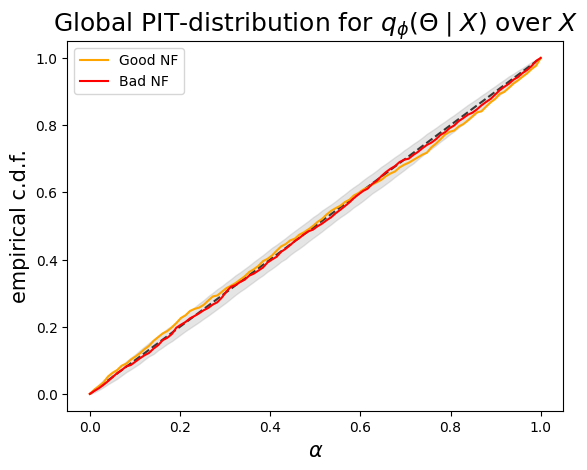

In [9]:
# PLOT EXPECTED PIT-DISTRIBUTION of the trained estimators
from valdiags.pp_plots import PP_plot_1D, cde_pit_values_zuko

# from data.feature_transforms import first_dim_only

# Compute PIT-values of the flows F_{Q|X_i}(Theta_i)
# [PIT(Theta_i, X_i, npe_good) = F_{Q_good|X_i}(Theta_i)]
flow_joint_pit_values_good = cde_pit_values_zuko(theta_test, x_test, npe_good.flow)
# [PIT(Theta_i, X_i, npe_bad) = F_{Q_bad|X_i}(Theta_i)]
flow_joint_pit_values_bad = cde_pit_values_zuko(theta_test, x_test, npe_bad.flow)

# PP-plot of global PIT-distribution for both flows
# alpha-quantiles = [P_X,Theta(Z < alpha)]
alphas = np.linspace(0, 1, 100)
PP_plot_1D(
    PIT_values=[flow_joint_pit_values_good, flow_joint_pit_values_bad],
    alphas=alphas,
    colors=["orange", "red"],
    labels=["Good NF", "Bad NF"],
    title=r"Global PIT-distribution for $q_{\phi}(\Theta \mid X)$ over $X$",
    confidence_int=True,
    ylabel="empirical c.d.f.",
)


Let's look at the global l-c2st score. 

##### Global L-C2ST
The global l-c2st also consists in a cross-val score but for the **local** classifier with joint features $[Z,x]$ (results in an average l-c2st score over different locations in $x$-space). The scoring metrics we consider are the following:
- Accuracy (over both classes): `clf.predict([Z_n, x_n]) == y_n`
- Mean predictive probabilities (before activation) for class 0 over samples $z \sim \mathcal{N}(0,1)$ from class 0: `clf.predict_proba([Z_{0,n}, x_n])[:,0].mean()` (where  `Z_{0,n}` correspond to the datapoints with label `y_n = 0`)

    *--> this is the metric used to score l-c2st locally at a new observation $x_0$ for which we dont have samples from class 1*!

In [10]:
# Global test for lc2t (vanilla c2st but trained and eval on joint)
from valdiags.c2st import c2st_scores

joint_P_x = np.concatenate([base_dist_samples, x_cal_shuffled], axis=1)
joint_Q_x_good = np.concatenate([inv_flow_samples_cal_good, x_cal], axis=1)
joint_Q_x_bad = np.concatenate([inv_flow_samples_cal_bad, x_cal], axis=1)
joint_null = np.concatenate([base_dist_samples_2, x_cal], axis=1)

df_explc2st_good = pd.DataFrame( 
    c2st_scores(P=joint_P_x, Q=joint_Q_x_good, metrics=['accuracy', 'probas_mean'])[0]
)
df_explc2st_bad = pd.DataFrame(
    c2st_scores(P=joint_P_x, Q=joint_Q_x_bad, metrics=['accuracy', 'probas_mean'])[0]
)
df_explc2st_null = pd.DataFrame(
    c2st_scores(P=joint_P_x, Q=joint_null, metrics=['accuracy', 'probas_mean'])[0]
)

df_explc2st = pd.DataFrame({})

dfs = [pd.concat(
    [
        df.mean(axis=0).rename("mean"),
        df.std(axis=0).rename("std"),
    ], axis=1) for df in [df_explc2st_good, df_explc2st_bad, df_explc2st_null]]
df_explc2st = pd.concat(dfs, keys=["good_npe", "bad_npe", "null"])
df_explc2st.round(2)


mean   std
good_npe accuracy     0.52  0.01
         probas_mean  0.50  0.00
bad_npe  accuracy     0.60  0.01
         probas_mean  0.54  0.00
null     accuracy     0.49  0.02
         probas_mean  0.50  0.00

The global score of lc2st is higher than the vanilla c2st score for the bad NF: `accuracy ~ 0.6`. 

We also show the mean probability for class 0. It cannot be directly compared to the vanilla c2st score: yields lower scores, as it is a little bit more robust / less sensitive than the accuracy (cf. shift experiments). It also shows that the bad NF is off: `mean proba = 0.54`. 

**Interpretation:**
We manage to create a **link with x that captures that the bad NF is mostly off in the x-space**: concatenating $Z$ with $x$ here implicitly conditions every sample $Z$ implicitly on $x$ by applying the formula: $p(Z,x) = p(Z\mid x)p(x)$.

**Conclusion:**
This shows that the vanilla c2st is not a sufficient condition for global consistency. On the other hand, the global l-c2st is more sensitive to the connection to $x$-space and is thus more adapted to evaluating (global)consistency of conditional estimators. However it still remains a question if theoretically we can prove that this metric is a sufficient condition for global consistency or not. 

The big advantage of l-c2st is that it also allows to evaluate **local consistency**.



#### 2. Local Consistency
We evaluate the true target density and the trained estimators in $x_0 = [0,1]$.

#### True and estimated densities at $x_0$

/opt/miniconda3/envs/sbibm_new/lib/python3.10/site-packages/lampe/plots.py:78: RuntimeWarning: invalid value encountered in divide
  levels = (levels - levels.min()) / (levels.max() - levels.min())
/opt/miniconda3/envs/sbibm_new/lib/python3.10/site-packages/lampe/plots.py:261: RuntimeWarning: invalid value encountered in divide
  levels = (creds - creds.min()) / (creds.max() - creds.min())


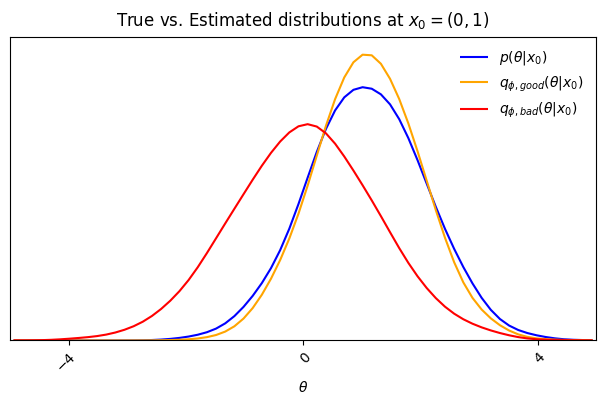

In [11]:
from valdiags.graphical_diagnostics import multi_corner_plots

# Observation
x_0 = torch.FloatTensor([[0, 1]])

# Samples from the true conditional distribution Theta|X=x_0
samples_theta_x_0 = torch.FloatTensor(
    [data_gen.sample_theta(x_0) for i in range(len(x_cal))]
).reshape(-1, 1)

# Samples from the estimated distributions at x_0
samples_good = npe_good.flow(x_0).sample((5000,))[:,:,0]
samples_bad = npe_bad.flow(x_0).sample((5000,))[:,:,0]

# Plot
samples = [samples_theta_x_0.numpy(), samples_good.numpy(), samples_bad.numpy()]
legends = [r'$p(\theta | x_0)$', r'$q_{\phi, good}(\theta | x_0)$', r'$q_{\phi, bad}(\theta | x_0)$']
colors = ['blue', 'orange','red']
title = r"True vs. Estimated distributions at $x_0 = (0,1)$"

multi_corner_plots(samples, legends, colors, title=title, creds=[], labels=[r'$\theta$'], figsize=(6,4), domain=(torch.tensor([-5]),torch.tensor([5])))
# plt.hist(samples_theta_x_0.numpy(), bins=50, color='blue', alpha=0.3, density=True)
# plt.hist(samples_good.numpy(), bins=50, color='orange', alpha=0.3, density=True)
# plt.hist(samples_bad.numpy(), bins=50, color='red', alpha=0.3, density=True)
plt.show()



- bad npe: negative bias and a little overdispersed
- good npe: seems fine.



##### Local Coverage
To vizualize this in terms of cdfs, we can compute the local PIT-distribution using the samples from the "true" target density at $x_0$, $p(\theta \mid x_0)$. The corresponding PP-plot below clearly shows the negative bias for the bad npe.

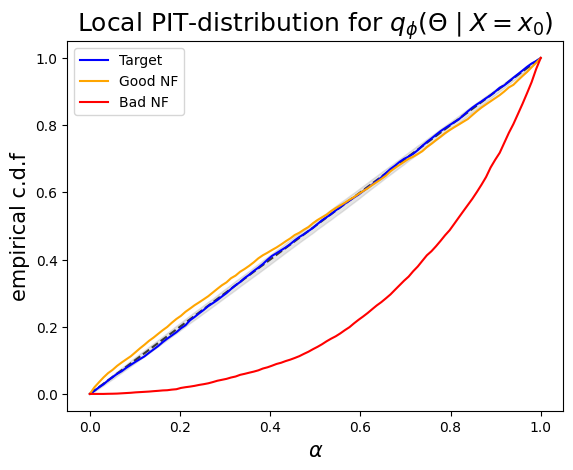

In [12]:
# Local PIT-distribution on samples Theta_{0,i} ~ Theta|X=x_0

# Compute PIT-values [PIT(Theta_{0,i}, X=x_0, p_true/good/bad) = F_{true/good/bad|x_0}(Theta_{0,i})]
true_local_pit_values = data_gen.true_pit_values(samples_theta_x_0, x_0, local=True)
flow_local_pit_values_good = cde_pit_values_zuko(
    samples_theta_x_0, x_0.repeat(5000, 1), flow=npe_good.flow,
)
flow_local_pit_values_bad = cde_pit_values_zuko(
    samples_theta_x_0, first_dim_only(x_0.repeat(5000, 1)), flow=npe_bad.flow,
)

# PP-plot of the local distribution
# alpha-quantiles = [P_{Theta|X}(Z < alpha)]
PP_plot_1D(
    PIT_values=[
        true_local_pit_values,
        flow_local_pit_values_good,
        flow_local_pit_values_bad,
    ],
    alphas=alphas,
    colors=["blue", "orange", "red"],
    labels=["Target", "Good NF", "Bad NF"],
    title=r"Local PIT-distribution for $q_{\phi}({\Theta \mid X=x_0)}$",
    confidence_int=True,
    ylabel="empirical c.d.f",
)


As reference-metric we compute the c2st score between the true (known because it's a toy-model) and estimated densities at x_0.

In [13]:
df_c2st_ref = pd.DataFrame({})
df_c2st_ref['bad NF'] = c2st_scores(samples_theta_x_0, npe_bad.flow(x_0).sample((5000,))[:,0], n_folds=10, metrics=['accuracy'])[0]['accuracy']
df_c2st_ref['good NF'] = c2st_scores(samples_theta_x_0, npe_good.flow(x_0).sample((5000,))[:,0], n_folds=10, metrics=['accuracy'])[0]['accuracy']

df_c2st_ref = pd.concat(
    [df_c2st_ref.mean(axis=0).rename("mean"), df_c2st_ref.std(axis=0).rename("std")], axis=1
)
df_c2st_ref.round(2)

,mean,std
bad NF,0.69,0.02
good NF,0.52,0.02


Or between the base distribution (normal) and the "true" distribution of the inverse transformation using samples from the true density: $T_{\phi}^{-1}(\Theta ; x_0)$ where $\Theta \sim p(\theta \mid x_0)$

In [14]:
inv_flow_samples_true_good = npe_good.flow(x_0).transform(samples_theta_x_0).detach()
inv_flow_samples_true_bad = npe_bad.flow(x_0).transform(samples_theta_x_0).detach()

df_c2st_ref = pd.DataFrame({})
df_c2st_ref['bad NF'] = c2st_scores(base_dist_samples, inv_flow_samples_true_bad, n_folds=10, metrics=['accuracy'])[0]['accuracy']
df_c2st_ref['good NF'] = c2st_scores(base_dist_samples, inv_flow_samples_cal_good, n_folds=10, metrics=['accuracy'])[0]['accuracy']

df_c2st_ref = pd.concat(
    [df_c2st_ref.mean(axis=0).rename("mean"), df_c2st_ref.std(axis=0).rename("std")], axis=1
)
df_c2st_ref.round(2)

,mean,std
bad NF,0.69,0.01
good NF,0.52,0.01


#### Local C2ST at $x_0$

##### Cross-val Score 
We predict probas at $x_0$ and evaluate different metrics over all cross-val folds.


In [15]:
from valdiags.lc2st import lc2st_scores

metrics = ["accuracy", "probas_mean"]

scores_good, probas_good = lc2st_scores(
    P=base_dist_samples,
    Q=inv_flow_samples_cal_good,
    x_P=x_cal_shuffled,
    x_Q=x_cal,
    x_eval=x_0,
    P_eval=base_dist_samples_2,
    metrics=metrics,
    n_folds=10,
    cross_val=True,
    single_class_eval=True,
)
df_lc2st_good = pd.DataFrame(scores_good)

scores_bad, probas_bad = lc2st_scores(
    P=base_dist_samples,
    Q=inv_flow_samples_cal_bad,
    x_P=x_cal_shuffled,
    x_Q=x_cal,
    x_eval=x_0,
    metrics=metrics,
    n_folds=10,
    cross_val=True,
    single_class_eval=True,
)
df_lc2st_bad = pd.DataFrame(scores_bad)

scores_null, probas_null = lc2st_scores(
    P=base_dist_samples,
    Q=base_dist_samples_2,
    x_P=x_cal_shuffled,
    x_Q=x_cal,
    x_eval=x_0,
    metrics=metrics,
    n_folds=10,
    cross_val=True,
    single_class_eval=True,
)
df_lc2st_null = pd.DataFrame(scores_null)


df_lc2st = pd.DataFrame({})

dfs = [
    pd.concat([df.mean(axis=0).rename("mean"), df.std(axis=0).rename("std"),], axis=1)
    for df in [df_lc2st_good, df_lc2st_bad, df_lc2st_null]
]
df_lc2st = pd.concat(dfs, keys=["good_npe", "bad_npe", "null"])
df_lc2st.round(2)


mean   std
good_npe accuracy     0.68  0.05
         probas_mean  0.50  0.00
bad_npe  accuracy     0.62  0.02
         probas_mean  0.59  0.01
null     accuracy     0.68  0.27
         probas_mean  0.50  0.01

- The mean of the predicted probabilities gives the results we were expecting: ~0.5 for the good NF and null hypothesis, ~0.6 for the bad NF. 

- The accuracy however shows large fluctuations (see good NPE or null hypothesis cases).

We can explain the reason for this in detail mathematically. For now trust the following result: 

- **If we score both classes, using accuracy works.** 
- **If we score only one class, mean proba is more adapted, gives the same result as if we would compute it on both classes, which is also consistent with the results obtained via the reference case (vanilla C2ST on true posterior samples).**

##### Histograms of all cross-val folds

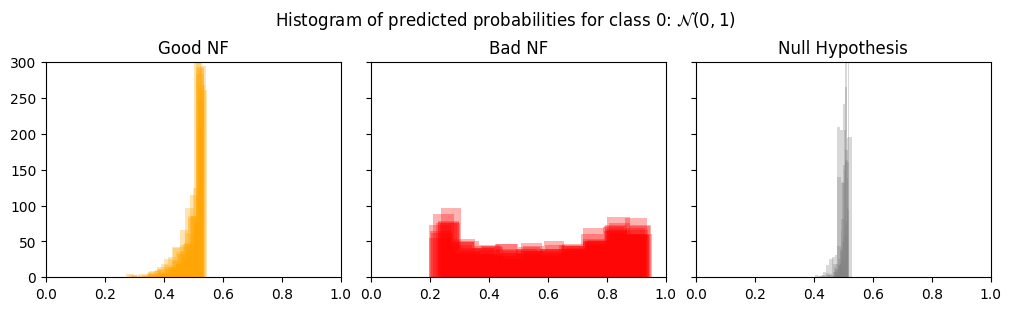

In [16]:
n_folds = 10
fig, axs = plt.subplots(1,3, figsize=(10, 3), constrained_layout=True, sharey=True)
for t in range(n_folds):
    axs[0].hist(probas_good[t],alpha=0.3, color='orange')
    axs[1].hist(probas_bad[t],alpha=0.3, color='red')
    axs[2].hist(probas_null[t],alpha=0.3, color='grey')
axs[0].set_xlim(0,1)
axs[0].set_ylim(0,300)
axs[0].set_title('Good NF')
axs[1].set_xlim(0,1)
axs[1].set_ylim(0,300)
axs[1].set_title('Bad NF')
axs[2].set_xlim(0,1)
axs[2].set_ylim(0,300)
axs[2].set_title('Null Hypothesis')
plt.suptitle(r'Histogram of predicted probabilities for class 0: $\mathcal{N}(0,1)$')
plt.show()


##### Hyptothesis Test Diagnostics (evaluate w.r.t null-hypothesis)

We now proceed to the frequentist hypothesis test for local consistency. 

**Ensemble prediction:** We train an ensemble of 10 classifiers to get an ensemble-lc2st (more robust) for each estimator (good and bad npe). 

**Null hypothesis:** We also train $N_{null} = 100$ classifiers under the null hypothesis (discrimate between two sets of samples from the base distribution). These are the trials we can compare the performance of our estimator. 

**Test statistics:** It is defined by the metric we chose to evaluate our lc2st model with.
After predicting the probability of class 0 for serveral samples of the base-distribution at $x_0$ we can compute the:
- Mean of the vector: `probas_mean`
- Wasserstein distance to the dirac at 0.5: `w_dist`
- Total variation, i.e. euclidean distance between c.d.fs (of predicted probas and dirac): `TV`

*Comment: For the ensemble model, we apply the metric on the ensemble probability distribution (i.e. average probability over all ensemble-models): 
$T_e = \text{metric}(\frac{1}{10}\sum_{n=1}^{10}\text{probas}(\text{model}_n))$.*

**p-values:** The p-values for a given test-statistic are given py the expectation of the ensemble test statistic to be smaller than under the null hypothesis: 
$$p = \mathbb{P}(T_{e}< T_{null}) \approx \frac{1}{N_{null}}\sum_{n=1}^{N_{null}}\mathbb{1}_{(T_{e}< T_n)}$$
The test is rejected if $p<0.05$ where 0.05 corresponds to a onfidence level of 95%.

**95% confidence region:** it is defined by the 5% and 95% quantiles of the test-statistics obtained over all 100 trials under the null hypothesis.  

In [20]:
from valdiags.lc2st import t_stats_lc2st
from valdiags.c2st import t_stats_c2st

# metrics = ["probas_mean", "w_dist", "TV"]
metrics = ["accuracy", "probas_mean", "div", "mse"]

N_v = 10_000
P_eval = npe_good.flow(x_0[0]).base.sample((N_v,))

test_stats_good, probas_good_ens = t_stats_lc2st(
    P=base_dist_samples,
    Q=inv_flow_samples_cal_good,
    x_P=x_cal_shuffled,
    x_Q=x_cal,
    P_eval=P_eval,
    x_eval=x_0,
    metrics=metrics,
    null_hypothesis=False,
    return_probas=True,
    # kwargs for lc2st_scores
    clf_class=clf_class,
    clf_kwargs=clf_kwargs,
    n_ensemble=1,
    single_class_eval=True,
    cross_val=False,
)

test_stats_bad, probas_bad_ens = t_stats_lc2st(
    P=base_dist_samples,
    Q=inv_flow_samples_cal_bad,
    x_P=x_cal_shuffled,
    x_Q=x_cal,
    P_eval=P_eval,
    x_eval=x_0,
    metrics=metrics,
    null_hypothesis=False,
    return_probas=True,
    # kwargs for lc2st_scores
    clf_class=clf_class,
    clf_kwargs=clf_kwargs,
    n_ensemble=1,
    single_class_eval=True,
    cross_val=False,
)

null_dist = npe_good.flow(x_0[0]).base
n_trials_null = 100
list_P_null = [null_dist.sample((len(x_cal),)) for _ in range(2*n_trials_null)]
list_P_eval_null = [null_dist.sample((N_v,)) for _ in range(2*n_trials_null)]

test_stats_null, probas_null = t_stats_c2st(
    null_hypothesis=True,
    n_trials_null=n_trials_null,
    use_permutation=False,
    list_P_null=list_P_null,
    list_P_eval_null=list_P_eval_null,
    metrics=metrics,
    return_probas=True,
    # necessary kwargs for t_stats_c2st
    P=None,
    Q=None,
    # kwargs for c2st_scores
    clf_class=clf_class,
    clf_kwargs=clf_kwargs,
    n_ensemble=1,
    single_class_eval=True,
    cross_val=False,
)


Computing T under (H0) - permutation = False: 100%|██████████| 100/100 [00:31<00:00,  3.13it/s]


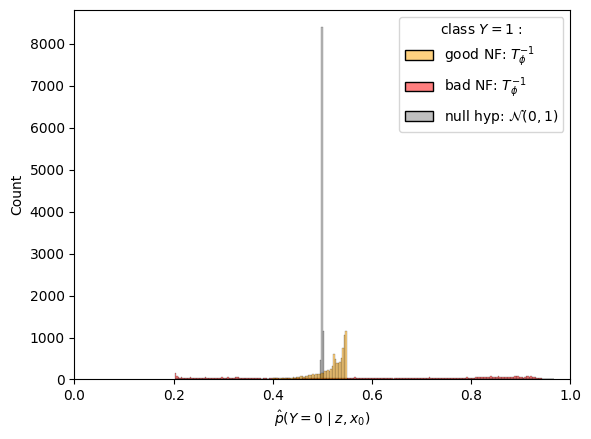

In [23]:
# plot predicted probas for x_0 
probas_z = np.concatenate(
    [
        probas_good_ens,
        probas_bad_ens,
        np.mean(probas_null, axis=0),
    ]
)
# grids = np.concatenate([grid.reshape(-1,1)]*30)
names = [r'good NF: $T^{-1}_{\phi}$']*10000+[r'bad NF: $T^{-1}_{\phi}$']*10000+[r'null hyp: $\mathcal{N}(0,1)$']*10000

df = pd.DataFrame({r'class $Y=1$ :': names, r'$\hat{p}(Y=0 \mid z,x_0)$': probas_z})

import seaborn as sns
sns.histplot(
        data=df, x=r"$\hat{p}(Y=0 \mid z,x_0)$",
        hue=r'class $Y=1$ :',  palette=['orange','red','grey']
)
plt.xlim(0,1)
plt.show()

In [24]:
# p-values
from valdiags.test_utils import compute_pvalue
p_values_good = {}
p_values_bad = {}
for m in metrics:
    p_values_good[m] = compute_pvalue(test_stats_good[m], test_stats_null[m])
    p_values_bad[m] = compute_pvalue(test_stats_bad[m], test_stats_null[m])

pd.concat(
    [
        pd.Series(p_values_good).rename("good_npe"),
        pd.Series(p_values_bad).rename("bad_npe"),
    ], axis=1
)



,good_npe,bad_npe
accuracy,0.14,0.3
probas_mean,0.01,0.0
div,0.00,0.0
mse,0.00,0.0


pvalues accuracy: 0.14 0.3
pvalues probas_mean: 0.01 0.0
pvalues div: 0.0 0.0
pvalues mse: 0.0 0.0


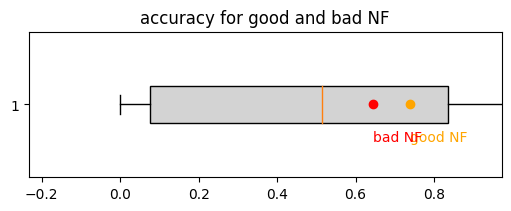

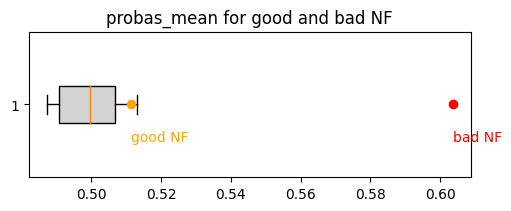

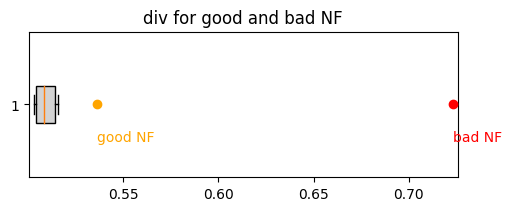

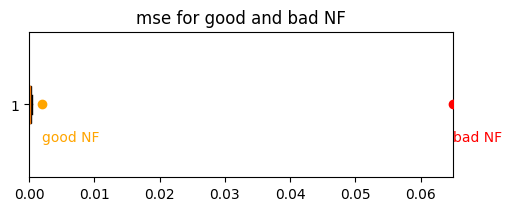

In [26]:
def box_plot_lc2st(
    scores, scores_null, labels, colors, title=r"Box plot", conf_alpha=0.05
):
    import matplotlib.cbook as cbook

    data = scores_null
    stats = cbook.boxplot_stats(data)[0]
    stats["q1"] = np.quantile(data, conf_alpha)
    stats["q3"] = np.quantile(data, 1 - conf_alpha)
    stats["whislo"] = min(data)
    stats["whishi"] = max(data)

    fig, ax = plt.subplots(1, 1, constrained_layout=True)
    bp = ax.bxp([stats], widths=0.1, vert=False, showfliers=False, patch_artist=True)
    bp["boxes"][0].set_facecolor("lightgray")
    ax.set_label(r"95% confidence interval$")
    ax.set_ylim(0.8, 1.2)
    ax.set_xlim(stats["whislo"] - np.std(data), max(scores) + np.std(data))

    for s, l, c in zip(scores, labels, colors):
        plt.text(s, 0.9, l, color=c)
        plt.scatter(s, 1, color=c, zorder=10)

    fig.set_size_inches(5, 2)
    plt.title(title)

for m in metrics:
    box_plot_lc2st(
        [test_stats_good[m], test_stats_bad[m]],
        test_stats_null[m],
        labels=["good NF", "bad NF"],
        colors=["orange", "red"],
        title=f"{m} for good and bad NF",
    )

    print(f'pvalues {m}:', p_values_good[m], p_values_bad[m])

<Axes: >

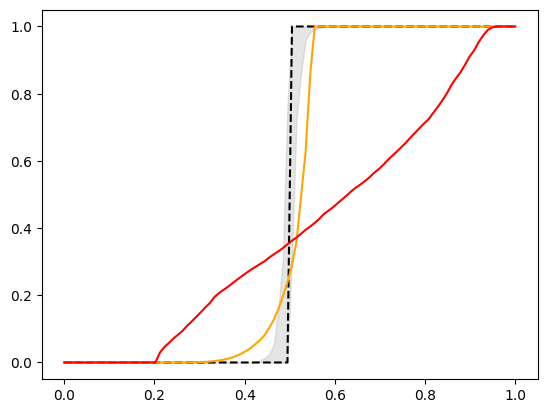

In [29]:
from valdiags.graphical_diagnostics import pp_plot_lc2st
pp_plot_lc2st([probas_good_ens, probas_bad_ens], probas_null, labels=['Good NF', 'Bad NF'], colors=['orange', 'red'])

The ensemble model for the good NF yields test statistics that are always in the 95% confidence region (in grey)

#### Interpretability: where can the classifier discriminate (or not)?
(cf. [Lee et al. (2018)])

Using the samples from the true conditional distribution $p(\theta \mid x_0)$ (which we only have in this toy example and not in a regular sbi setting), we can get samples from the inverse transformations and plot the histograms. 

We here compare $\mathcal{N}(0,1)$ to $p(T_{\phi}^{-1}(\theta, x_0) \mid x_0)$ which is the ultimate goal of the lc2st diagnostic.

/opt/miniconda3/envs/sbibm_new/lib/python3.10/site-packages/lampe/plots.py:78: RuntimeWarning: invalid value encountered in divide
  levels = (levels - levels.min()) / (levels.max() - levels.min())
/opt/miniconda3/envs/sbibm_new/lib/python3.10/site-packages/lampe/plots.py:261: RuntimeWarning: invalid value encountered in divide
  levels = (creds - creds.min()) / (creds.max() - creds.min())


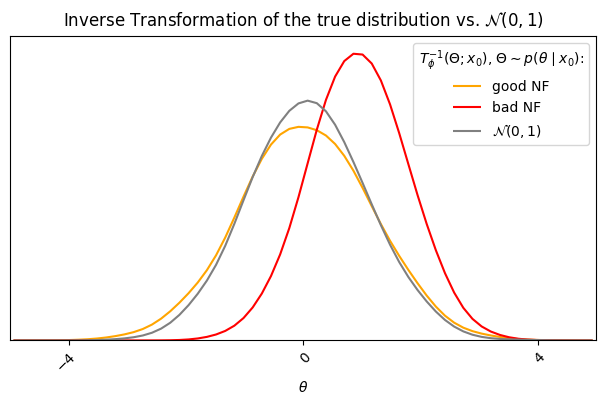

In [30]:
# Hist of the true conditional distributions: norm, inv-flow good/bad
inv_flow_samples_true_good = npe_good.flow(x_0).transform(samples_theta_x_0).detach().numpy()
inv_flow_samples_true_bad = npe_bad.flow(x_0).transform(samples_theta_x_0).detach().numpy()

# Plot of the true conditional distributions: norm, inv-flow good/bad
samples = [inv_flow_samples_true_good, inv_flow_samples_true_bad, base_dist_samples.numpy()]
legends = ["good NF", "bad NF", r'$\mathcal{N}(0,1)$']
colors = ['orange','red', 'grey']
title = r'Inverse Transformation of the true distribution vs. $\mathcal{N}(0,1)$'

multi_corner_plots(samples, legends, colors, title=title, creds=[], labels=[r'$\theta$'], figsize=(6,4), domain=(torch.tensor([-5]),torch.tensor([5])))
plt.legend(title = r'$T_{\phi}^{-1}(\Theta;x_0)$, $\Theta \sim p(\theta \mid x_0)$:')
# plt.hist(inv_flow_samples_true_good, bins=50, color='orange', alpha=0.3, density=True) 
# plt.hist(inv_flow_samples_true_bad, bins = 50, color='red', alpha=0.3, density=True) 
# plt.hist(base_dist_samples.numpy(), bins=50, color='grey', alpha=0.3, density=True) 
plt.show()



This shows us what we should expect from our predicted probabilities: regions where the norm pdf (grey) nis higher than the other (orange or red), the predicted probas should be above 0.5, otherwise they should be below 0.5. 

It relates to the exact opposite case of what we saw in the pdf plot of the learned distributions at $x_0$: 
- negative bias becomes positive bias
- overdispersion becomes underdispersion

WHY? inverse transformation? always the case? just inverse affine transformation of the MAF...?


In [35]:
# train classifiers
from valdiags.lc2st import train_lc2st, eval_lc2st
from sklearn.neural_network import MLPClassifier


n_trials = 10
clfs_good = []
clfs_bad = []
clfs_null = []

for t in range(n_trials): 
        # predict probas 
        # good and bad npe
        clf_good = train_lc2st(base_dist_samples, inv_flow_samples_cal_good, x_cal, x_cal, clf=MLPClassifier(**clf_kwargs))
        clfs_good.append(clf_good)
        clf_bad = train_lc2st(base_dist_samples, inv_flow_samples_cal_bad, x_cal, x_cal, clf=MLPClassifier(**clf_kwargs))
        clfs_bad.append(clf_bad)

        clf_null = train_lc2st(base_dist_samples, base_dist_samples_2, x_cal, x_cal, clf=MLPClassifier(**clf_kwargs))
        clfs_null.append(clf_null)


In [42]:
grid = np.linspace(-5,5,1000)
eval_lc2st(grid.reshape(-1,1), x_0, clfs_good[0])

(0.194,
 array([0.20163465, 0.20213795, 0.20264219, 0.20314736, 0.20365347,
        0.20416052, 0.20466851, 0.20517743, 0.20568729, 0.20619809,
        0.20670983, 0.20722251, 0.20773613, 0.20825068, 0.20876618,
        0.20928261, 0.20979998, 0.21031829, 0.21083754, 0.21135773,
        0.21187885, 0.21240092, 0.21292392, 0.21344787, 0.21397275,
        0.21449857, 0.21502533, 0.21555302, 0.21608166, 0.21661124,
        0.21714175, 0.2176732 , 0.21820559, 0.21873892, 0.21927318,
        0.21980839, 0.22034453, 0.22088161, 0.22141962, 0.22195857,
        0.22249846, 0.22303929, 0.22358105, 0.22412375, 0.22466739,
        0.22521196, 0.22575747, 0.22630391, 0.22685129, 0.2273996 ,
        0.22794885, 0.22849903, 0.22905015, 0.2296022 , 0.23015518,
        0.23070909, 0.23126394, 0.23181972, 0.23237643, 0.23293408,
        0.23349265, 0.23405216, 0.23461259, 0.23517396, 0.23572102,
        0.23625155, 0.23678291, 0.23731509, 0.23784809, 0.23838192,
        0.23891657, 0.23945205, 0.239988

##### Predict over grid 

10


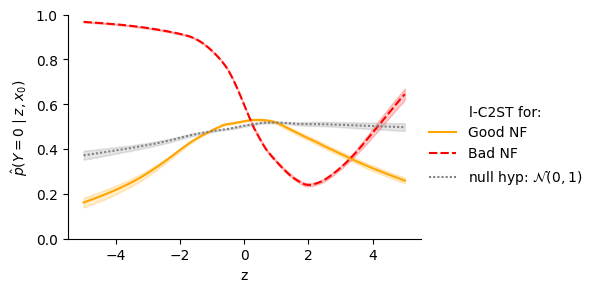

In [45]:
# predict over grid 
grid = np.linspace(-5,5,1000)

probas_grid_good = []
probas_grid_bad = []
probas_grid_null = []

for t in range(n_trials): 
    probas_grid_good.append(eval_lc2st(grid.reshape(-1,1), x_0, clf=clfs_good[t])[1])
    probas_grid_bad.append(eval_lc2st(grid.reshape(-1,1), x_0, clf=clfs_bad[t])[1])
    probas_grid_null.append(eval_lc2st(grid.reshape(-1,1), x_0, clf=clfs_null[t])[1])

print(len(probas_grid_good))

# plot predicted probas over grid
probas = np.concatenate(
    [
        np.concatenate(probas_grid_good),
        np.concatenate(probas_grid_bad),
        np.concatenate(probas_grid_null)
    ]
)
grids = np.concatenate([grid.reshape(-1,1)]*30)
names = [r'Good NF']*10000+[r'Bad NF']*10000+ [r'null hyp: $\mathcal{N}(0,1)$']*10000

df = pd.DataFrame({r'l-C2ST for:': names, r'$\hat{p}(Y=0 \mid z,x_0)$': probas, 'z': grids[:,0]})

import seaborn as sns

g = sns.relplot(
        data=df, x="z", y=r"$\hat{p}(Y=0 \mid z,x_0)$",
        hue=r'l-C2ST for:', style=r'l-C2ST for:', kind="line", palette=['orange','red', 'grey'],
        height=3,
        aspect=1.5,
    )

plt.ylim(0,1)
plt.show()

Regions above (below) the grey line indicate regions where the estimator is over/under confident w.r.t to the true posterior. 

Results:
- red (bad): high probas (>0.5) until $z\approx0.5$ (which is where the norm pdf is indeed higher) and low probas (<0.5) until the end (which is where the red pdf is higher) --> big negative bias
- orange (good): pretty close to the null, can show small deviances.
- blue (norm/null): always around 0.5. (small border effects)

Nature of inconsistencies in 1D:
- Bias: The location (resp.  amplitude) of the peaks indicates positive/negative (resp. small/big) bias.
- Dispersion: If there is a symmetry in the curve w.r.t to $z=0$ (e.g. lower-higher-lower), this indicates under/over dispersion. 

In higher dimensions we cannot talk/conclude about bias or over/underdispersion, but we can identify the regions (in the normal space) where one or the other pdf in higher, and where they are equal:

##### Predict only for class 0 and look at proba-intensity

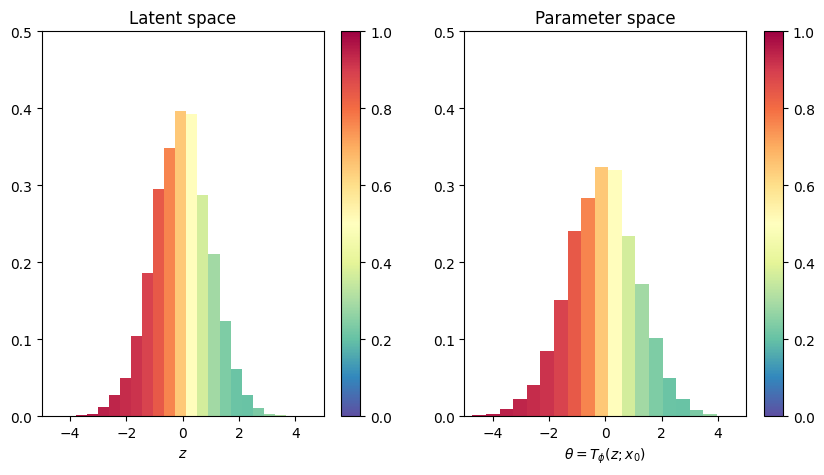

In [64]:
from valdiags.graphical_diagnostics import compute_dfs_with_probas_marginals, eval_space_with_proba_intensity

fig, axs = plt.subplots(1,2, figsize=(10,5))

# Latent z-space
df_probas = compute_dfs_with_probas_marginals(probas=probas_bad_ens, P_eval=P_eval)
eval_space_with_proba_intensity(df_probas=df_probas['0'], ax=axs[0])
axs[0].set_xlim(-5,5)
axs[0].set_ylim(0,0.5)
axs[0].set_xlabel(r'$z$')
axs[0].set_title('Latent space')


# Parameter space
fwd_flow = npe_bad.flow(x_0).transform.inv(torch.FloatTensor(P_eval).reshape(-1,1)).detach()
df_probas = compute_dfs_with_probas_marginals(probas=probas_bad_ens, P_eval=fwd_flow)
eval_space_with_proba_intensity(df_probas=df_probas['0'], ax=axs[1])
axs[1].set_xlim(-5,5)
axs[1].set_ylim(0,0.5)
axs[1].set_xlabel(r'$\theta = T_\phi(z;x_0)$')
axs[1].set_title('Parameter space')

plt.show()

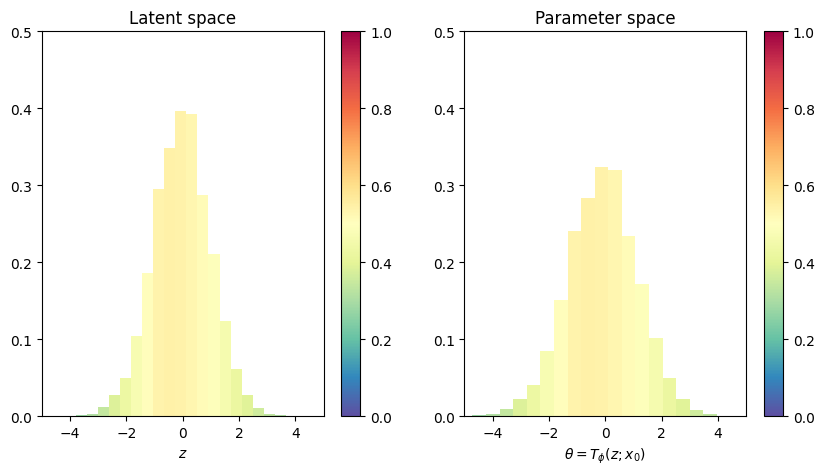

In [65]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

# Latent z-space
df_probas = compute_dfs_with_probas_marginals(probas=probas_good_ens, P_eval=P_eval)
eval_space_with_proba_intensity(df_probas=df_probas['0'], ax=axs[0])
axs[0].set_xlim(-5,5)
axs[0].set_ylim(0,0.5)
axs[0].set_xlabel(r'$z$')
axs[0].set_title('Latent space')


# Parameter space
fwd_flow = npe_bad.flow(x_0).transform.inv(torch.FloatTensor(P_eval).reshape(-1,1)).detach()
df_probas = compute_dfs_with_probas_marginals(probas=probas_good_ens, P_eval=fwd_flow)
eval_space_with_proba_intensity(df_probas=df_probas['0'], ax=axs[1])
axs[1].set_xlim(-5,5)
axs[1].set_ylim(0,0.5)
axs[1].set_xlabel(r'$\theta = T_\phi(z;x_0)$')
axs[1].set_title('Parameter space')

plt.show()

We could maybe use this result to correct the posterior / do smart sampling by re-weightening according to the intensity of the predicted probabilities. 

#### Posterior correction

##### Density

**In theory:**

The optimal LC2ST-classifier predicts $\mathbb{P}(Y=1\mid z, x_0)$ as:
$$d^*(z,x_0) = \frac{p(z\mid x_0)}{p(z\mid x_0) + \mathcal{N}(z)}$$
where $z\sim \mathcal{N}(0,1)$ (class $Y=0$) or $z=T_{\phi}^{-1}(\theta,x_0)$ (class $Y=1$). 

From there we define the ratio:
$$r^*(z,x_0) = \frac{d^*(z,x_0)}{1-d^*(z,x_0)} = \frac{p(z\mid x_0)}{\mathcal{N}(z)}$$

Which also means that in the latent $z$-space we have:
$$p(z\mid x_0) = \mathcal{N}(z)\times r^*(z,x_0)$$

Now the true posterior distribution can be expressed using the ratio and the estimated density:
1. We apply a change of variables using the invrse flow-transformation: $p(\theta \mid x_0) = p(T_{\phi}^{-1}(\theta ,x_0)\mid x_0) \left|\operatorname{det} J_{T_{\phi}^{-1}}(\theta; x)\right|$
2. Use the expression of the pdf $p(z\mid x_0)$ with the ratio to define the pdf of the inverse flow-transformation conditioned on $x_0$: $p(T_{\phi}^{-1}(\theta; x_0)\mid x_0) = \mathcal{N}(T_{\phi}^{-1}(\theta; x_0))\times r^*(T_{\phi}^{-1}(\theta; x_0),x_0)$
3. Combining 1. and 2. we get:
$p(\theta \mid x_0) = \mathcal{N}(T_{\phi}^{-1}(\theta; x_0))\times r^*(T_{\phi}^{-1}(\theta; x_0),x_0) \left|\operatorname{det} J_{T_{\phi}^{-1}}(\theta; x)\right|$
4. We recognize the density of the flow as: $q_{\phi}(\theta \mid x_0) = \mathcal{N}(T_{\phi}^{-1}(\theta; x_0))\left|\operatorname{det} J_{T_{\phi}^{-1}}(\theta; x)\right|$ which means that finally we get:
$$p(\theta \mid x_0) = q_{\phi}(\theta \mid x_0)\times r^*(T_{\phi}^{-1}(\theta; x_0),x_0)$$

**In practice:**

The function `eval_lc2st(z, x_0, clf)` outputs an estimate $\hat{d}_0(z,x_0)$ of $\mathbb{P}(Y=0\mid z, x_0) = 1-\mathbb{P}(Y=1\mid z, x_0) = 1-d^*(z,x_0)$ (using the trained classifier `clf`). The ratio we consider for the posterior correction is therefore: 
$$\hat{r}(z,x_0) = \frac{1-\hat{d}_0(z,x_0)}{\hat{d}_0(z,x_0)}$$
and the new *corrected* approximate posterior is:
$$p(\theta \mid x_0) \approx q_{\phi, corr}(\theta \mid x_0) = q_{\phi}(\theta \mid x_0)\times \hat{r}(T_{\phi}^{-1}(\theta; x_0),x_0)$$

In [71]:
def correct_density_on_grid(estimator, x_0, grid, clfs_ensemble):
    grid_torch = torch.FloatTensor(grid[:, None])
    grid_inv = estimator.flow(x_0).transform(grid_torch).detach()

    base_dist_pdf = estimator.flow(x_0).base.log_prob(grid_torch).exp()
    estimator_pdf = estimator.flow(x_0).log_prob(grid_torch).detach().exp()

    # predict probas
    probas_grid = []
    probas_grid_inv = []
    for t in range(len(clfs_ensemble)):
        probas_grid.append(eval_lc2st(grid.reshape(-1,1), x_0, clf=clfs_ensemble[t])[1])
        probas_grid_inv.append(eval_lc2st(grid_inv, x_0, clf=clfs_ensemble[t])[1])

    d = np.mean(probas_grid, axis=0)
    r = (1 - d) / d

    d_inv = np.mean(probas_grid_inv, axis=0)
    r_inv = (1 - d_inv) / d_inv

    corrected_base = base_dist_pdf * r
    corrected_estimator = estimator_pdf * r_inv

    return base_dist_pdf, corrected_base, estimator_pdf, corrected_estimator

def plot_corrected_z(base_dist_pdf, corrected_base, grid, inv_flow_samples_ref):
        plt.figure(figsize=(8,5))
        plt.plot(grid, base_dist_pdf, label=r"norm pdf: $\mathcal{N}(z)$", color='grey')
        plt.plot(grid, corrected_base, label=r"corrected: $\mathcal{N}(z)*\hat{r}(z, x_0)$", color='coral')
        plt.hist(
            inv_flow_samples_ref,
            bins=100,
            color="red",
            alpha=0.3,
            density=True,
            label=r"Samples $T_{\phi}^{-1}(\Theta, x_0)\mid x_0$",
        )
        plt.xlabel("z")
        plt.legend()
        plt.title("Latent Z-space")
        plt.show()

def plot_corrected_theta(estimator_pdf, corrected_estimator, ref_pdf, grid, posterior_samples_ref):
        plt.figure(figsize=(8,5))
        plt.plot(grid, estimator_pdf, color="red", label=r"NF: $q_{\phi}(\theta\mid x_0)$")
        plt.plot(grid, corrected_estimator, color="coral", label=r"corrected: $q_{\phi}(\theta\mid x_0)*\hat{r}(T_{\phi}^{-1}(\theta, x_0), x_0)$") # correct the normal pdf... p_N(T-1)=q_phi
        plt.plot(grid, ref_pdf, label=r"True posterior $p(\theta \mid x_0)$")
        plt.hist(
            posterior_samples_ref,
            bins=100,
            density=True,
            alpha=0.3,
            color="blue",
            label=r"Samples: $\Theta \mid x_0$",
        )
        plt.xlabel(r"$\theta$")
        plt.legend()
        plt.title(r"Parameter $\theta$-space")
        plt.show()

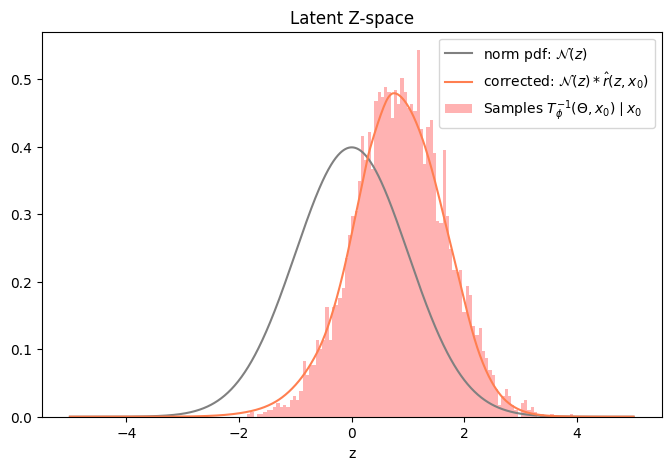

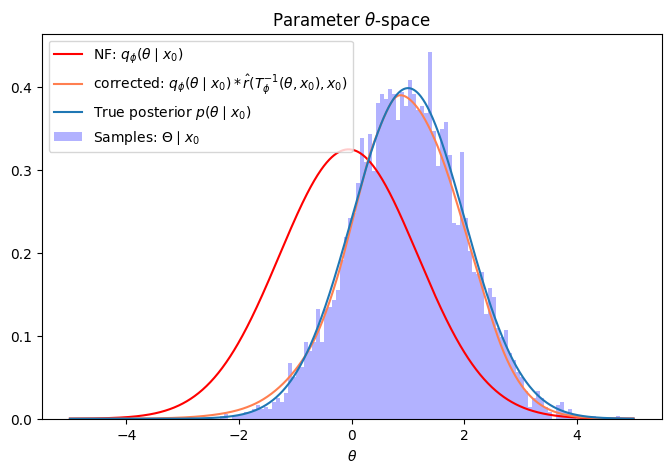

In [72]:
norm_pdf, corrected_norm_bad, bad_pdf, corrected_bad = correct_density_on_grid(npe_bad, x_0, grid, clfs_bad)
plot_corrected_z(norm_pdf, corrected_norm_bad, grid, inv_flow_samples_true_bad)
from scipy.stats import norm
ref_pdf = norm(1,1).pdf(grid)
plot_corrected_theta(bad_pdf, corrected_bad, ref_pdf, grid, samples_theta_x_0.numpy())

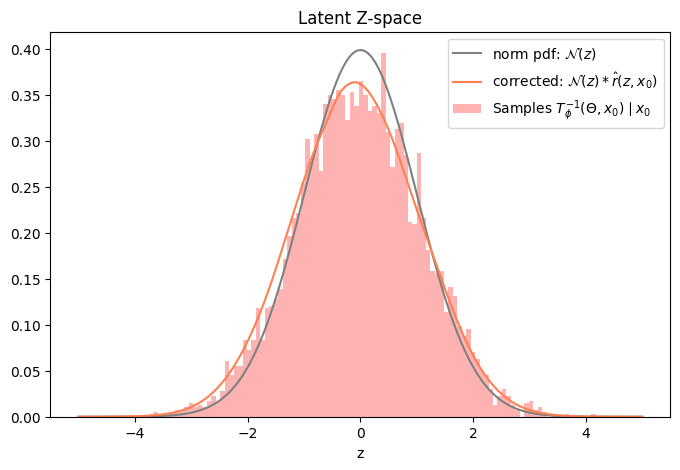

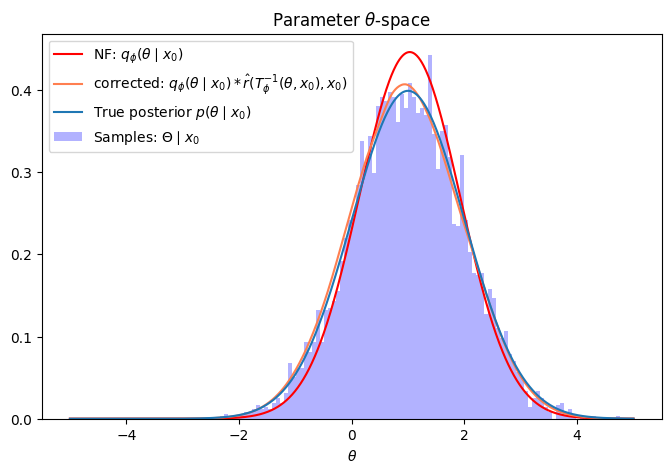

In [73]:
norm_pdf, corrected_norm_good, good_pdf, corrected_good = correct_density_on_grid(npe_good, x_0, grid, clfs_good)
plot_corrected_z(norm_pdf, corrected_norm_good, grid, inv_flow_samples_true_good)
from scipy.stats import norm
ref_pdf = norm(1,1).pdf(grid)
plot_corrected_theta(good_pdf, corrected_good, ref_pdf, grid, samples_theta_x_0.numpy())

##### Sampling

Rejection sampling... TODO